# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [84]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [85]:
# Use this space for any additional import statements you need


In [86]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
# all_language_emojis = set()

# for country in emoji.UNICODE_EMOJI : 
#     for em in emoji.UNICODE_EMOJI[country] : 
#         all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters.
    """

    # Place your Module 2 solution here
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = len("".join(tokens))
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print("The five most common tokens are: ", Counter(tokens).most_common(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


    
def is_emoji(s):
    return emoji.is_emoji(s)

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    
    tokens_no_sw = [token for token in tokens if not token in sw]
    
    return(tokens_no_sw)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    tokens = [item.lower() for item in whitespace_pattern.split(text)]

    return(tokens)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [87]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "M1 Results/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [88]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [89]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([twitter_data, twitter_data_2])
    
del(twitter_data_2)

In [90]:
# read in the lyrics here

artist_folders = os.listdir(data_location + lyrics_folder)

artist_lyrics_d = dict()

for artist in artist_folders :
    
    artist_lyrics_d[artist] = dict()
    
    artist_files = os.listdir(data_location + lyrics_folder + artist)
    
    for f_name in artist_files:
        
        # I stored the lyrics data in a dictionary with 
        # two dimensions of keys: artist and song. 
        # The value was the file contents. 
        with open(data_location + lyrics_folder + artist + "/" + f_name) as infile : 
            
            file_contents = infile.read()
            artist_lyrics_d[artist][f_name] = file_contents

In [91]:
filename_list = []
song_text_list = []

for k,v in artist_lyrics_d["cher"].items():
    filename_list.append(k)
    song_text_list.append(v)

data = {'filename': filename_list, 'lyrics': song_text_list}
lyrics_data = pd.DataFrame.from_dict(data)
lyrics_data['artist'] = "cher"

In [92]:
filename_list = []
song_text_list = []

for k,v in artist_lyrics_d["robyn"].items():
    filename_list.append(k)
    song_text_list.append(v)
    
data_2 = {'filename': filename_list, 'lyrics': song_text_list}
lyrics_data_2 = pd.DataFrame.from_dict(data_2)

lyrics_data_2['artist'] = "robyn"

lyrics_data = pd.concat([lyrics_data, lyrics_data_2])
    
del(lyrics_data_2)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove punctuation
* Split on whitespace
* Remove stopwords (optional)

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove punctuation other than emojis or hashtags
* Split on whitespace
* Remove stopwords

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [93]:
#Removing song titles

lyrics_data["song_title"] = lyrics_data["lyrics"].str.split("\n\n\n\n", expand=True)[0]
lyrics_data["lyrics"] = lyrics_data["lyrics"].str.split("\n\n\n\n", expand=True)[1]
lyrics_data["lyrics"] = lyrics_data["lyrics"].str.replace("\n"," ")

In [94]:
lyrics_data

,filename,lyrics,artist,song_title
0,cher_88degrees.txt,"Stuck in L.A., ain't got no friends And so Ho...",cher,"""88 Degrees"""
1,cher_adifferentkindoflovesong.txt,What if the world was crazy and I was sane Wou...,cher,"""A Different Kind Of Love Song"""
2,cher_afterall.txt,"Well, here we are again I guess it must be fat...",cher,"""After All"""
3,cher_again.txt,Again evening finds me at your door Here to a...,cher,"""Again"""
4,cher_alfie.txt,"What's it all about, Alfie? Is it just for the...",cher,"""Alfie"""
...,...,...,...,...
99,robyn_wedancetothebeat114528.txt,We dance to the beat We dance to the beat We d...,robyn,"""We Dance To The Beat"""
100,robyn_wheredidourlovego.txt,Thoughts about you and me Thinkin' about what...,robyn,"""Where Did Our Love Go"""
101,robyn_whosthatgirl.txt,Good girls are pretty like all the time I'm ju...,robyn,"""Who's That Girl"""
102,robyn_witheveryheartbeat.txt,Maybe we could make it all right We could make...,robyn,"""With Every Heartbeat"""


In [95]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [96]:
lyrics_data

,filename,lyrics,artist,song_title,tokens,num_tokens
0,cher_88degrees.txt,"Stuck in L.A., ain't got no friends And so Ho...",cher,"""88 Degrees""","[stuck, la, aint, got, friends, hollywood, nut...",181
1,cher_adifferentkindoflovesong.txt,What if the world was crazy and I was sane Wou...,cher,"""A Different Kind Of Love Song""","[world, crazy, sane, would, strange, cant, bel...",134
2,cher_afterall.txt,"Well, here we are again I guess it must be fat...",cher,"""After All""","[well, guess, must, fate, weve, tried, deep, i...",121
3,cher_again.txt,Again evening finds me at your door Here to a...,cher,"""Again""","[evening, finds, door, ask, could, try, dont, ...",35
4,cher_alfie.txt,"What's it all about, Alfie? Is it just for the...",cher,"""Alfie""","[whats, alfie, moment, live, whats, sort, alfi...",67
...,...,...,...,...,...,...
99,robyn_wedancetothebeat114528.txt,We dance to the beat We dance to the beat We d...,robyn,"""We Dance To The Beat""","[dance, beat, dance, beat, dance, beat, dance,...",221
100,robyn_wheredidourlovego.txt,Thoughts about you and me Thinkin' about what...,robyn,"""Where Did Our Love Go""","[thoughts, thinkin, used, love, strong, one, d...",54
101,robyn_whosthatgirl.txt,Good girls are pretty like all the time I'm ju...,robyn,"""Who's That Girl""","[good, girls, pretty, like, time, im, pretty, ...",169
102,robyn_witheveryheartbeat.txt,Maybe we could make it all right We could make...,robyn,"""With Every Heartbeat""","[maybe, could, make, right, could, make, bette...",105


In [97]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [98]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
70490,cher,I’m just here for the Real Housewives tea and ...,"[i’m, real, housewives, tea, hot, guys, ☕️, 💦,..."
2219882,cher,"Dancer, Artist, Pet lover, Funny...yea lol tha...","[dancer, artist, pet, lover, funnyyea, lol, th..."
3961695,cher,JLO Kelly C Lilian G Lilly Singh #BiSexual #Lo...,"[jlo, kelly, c, lilian, g, lilly, singh, #bise..."
1529969,cher,"🇭🇰 Hong Kong 📍 RLP, Deutschland 🌈 illustrator ...","[🇭🇰, hong, kong, 📍, rlp, deutschland, 🌈, illus..."
679539,cher,🌈🥝💞 I’m a little girl who's trying to survive ...,"[🌈🥝💞, i’m, little, girl, whos, trying, survive..."
1043641,cher,Alles rund um den geilsten Fernsehsender der W...,"[alles, rund, um, den, geilsten, fernsehsender..."
2100703,cher,"Lover of books and writing. Finn 🐶💚, Sarcasm, ...","[lover, books, writing, finn, 🐶💚, sarcasm, pun..."
20259,cher,"ǝʌıl ☁️ 𝚖𝚘𝚛𝚎 𝚎𝚜𝚙𝚛𝚎𝚜𝚜𝚘, 𝚕𝚎𝚜𝚜 𝚍𝚎𝚙𝚛𝚎𝚜𝚜𝚘. 𝚖𝚘𝚛𝚎 𝚌𝚊𝚏...","[ǝʌıl, ☁️, 𝚖𝚘𝚛𝚎, 𝚎𝚜𝚙𝚛𝚎𝚜𝚜𝚘, 𝚕𝚎𝚜𝚜, 𝚍𝚎𝚙𝚛𝚎𝚜𝚜𝚘, 𝚖𝚘𝚛..."
280336,cher,I'm a social butterfly who loves music (old sc...,"[im, social, butterfly, loves, music, old, sch..."
1436451,cher,Jersey girl living in California. Realtor East...,"[jersey, girl, living, california, realtor, ea..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: Tokenization is not removing all numbers, we should remove numbers in order to have a better text analysis 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [105]:

cher_tokens = []

for c in lyrics_data[lyrics_data['artist'] == "cher"]["tokens"]:
    
    cher_tokens.extend(c)
    
robyn_tokens = []

for r in lyrics_data[lyrics_data['artist'] == "robyn"]["tokens"]:
    
    robyn_tokens.extend(r)

In [107]:
# your code here
descriptive_stats(cher_tokens, verbose=True)
descriptive_stats(robyn_tokens, verbose=True)

There are 35549 tokens in the data.
There are 3685 unique tokens in the data.
There are 169306 characters in the data.
The lexical diversity is 0.104 in the data.
The five most common tokens are:  [('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332)]
There are 15145 tokens in the data.
There are 2140 unique tokens in the data.
There are 73005 characters in the data.
The lexical diversity is 0.141 in the data.
The five most common tokens are:  [('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 249)]


[15145, 2140, 0.1413007593265104, 73005]

Q: what observations do you make about these data? 

A: There is more lexical diversity for 'robyn' with 0.141. This could be due to this artist having less songs than Cher.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

### Calculating the Lyrics Group Comparison Concentration Ratio

In [117]:
# your code here

all_lyrics_tokens = list(set(cher_tokens + robyn_tokens) - {''})

n = 5

#********************
robyn_l_counts = []

for l_tok in all_lyrics_tokens:
    count = robyn_tokens.count(l_tok)
    robyn_l_counts.append(count)

#********************
cher_l_counts = []

for l_tok in all_lyrics_tokens:
    count = cher_tokens.count(l_tok)
    cher_l_counts.append(count)

In [143]:
comparison_df = pd.DataFrame({"Token": all_lyrics_tokens,
                              "cher_lyrics_count" : cher_l_counts, 
                              "robyn_lyrics_count" : robyn_l_counts})

# Calculating the concentration
comparison_df["Concentration_cher_lyrics"] =  comparison_df["cher_lyrics_count"] / len(cher_tokens)
comparison_df["Concentration_robyn_lyrics"] =  comparison_df["robyn_lyrics_count"] / len(robyn_tokens)


# Creating Passes cutoff column
comparison_df["Passes_cutoff"] = (comparison_df["cher_lyrics_count"] > n) & (comparison_df["robyn_lyrics_count"] > n)

# Creating Ratio column
# Very rare words can easily create infinite ratios!!
comparison_df["Ratio"] = comparison_df["Concentration_cher_lyrics"] / comparison_df["Concentration_robyn_lyrics"]

# Converting concentration values into Strings that show as percentages
comparison_df["Concentration_cher_lyrics"] = comparison_df["Concentration_cher_lyrics"].astype(float).map("{:.4%}".format)
comparison_df["Concentration_robyn_lyrics"] = comparison_df["Concentration_robyn_lyrics"].astype(float).map("{:.4%}".format)

# The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora
comparison_df[comparison_df["Passes_cutoff"] == True].sort_values(by=['Ratio'], ascending=False).head(10)

,Token,cher_lyrics_count,robyn_lyrics_count,Concentration_cher_lyrics,Concentration_robyn_lyrics,Passes_cutoff,Ratio
611,find,135,6,0.3798%,0.0396%,True,9.585713
4376,enough,124,7,0.3488%,0.0462%,True,7.546847
85,man,201,12,0.5654%,0.0792%,True,7.136031
112,believe,139,11,0.3910%,0.0726%,True,5.383491
3015,well,163,16,0.4585%,0.1056%,True,4.340198
3115,hope,56,6,0.1575%,0.0396%,True,3.976296
3063,home,102,11,0.2869%,0.0726%,True,3.950476
476,till,55,6,0.1547%,0.0396%,True,3.905290
1351,many,52,6,0.1463%,0.0396%,True,3.692275
626,last,48,6,0.1350%,0.0396%,True,3.408253


### Calculating the Twitter description Group Comparison Concentration Ratio

In [210]:
#********* ALL TOKENS ********************************
# Create a Counter dictionary with ALL tokens
all_twitter_counter = Counter()
twitter_data["tokens"].map(all_twitter_counter.update)
# Drop missing values
del all_twitter_counter['nan']

# Set all values of Counter Dictionary to Zero
all_twitter_counter =  { x:0 for x in all_twitter_counter}

# Convert dictionary back to Counter
all_twitter_counter = Counter(all_twitter_counter)

# Create a list with all Tokens: all_twitter_tokens
all_twitter_tokens = list(all_twitter_counter.keys())

#********* Cher ********************************
# Update the Counter with only Cher's token counts
twitter_data[twitter_data["artist"] == "cher"]["tokens"].map(all_twitter_counter.update)
del all_twitter_counter['nan']

# Convert Cher's token counts into a list: cher_tw_counts
cher_tw_counts = list(all_twitter_counter.values())

#********* Robyn ********************************
# Set all values of Counter Dictionary Back to Zero
all_twitter_counter =  { x:0 for x in all_twitter_counter}
# Convert dictionary back to Counter
all_twitter_counter = Counter(all_twitter_counter)

# Update the Counter with only Robyn's token counts
twitter_data[twitter_data["artist"] == "robyn"]["tokens"].map(all_twitter_counter.update)
del all_twitter_counter['nan']

# Convert Robyn's token counts into a list: robyn_tw_counts
robyn_tw_counts = list(all_twitter_counter.values())

In [211]:
n = 5

comparison_tw_df = pd.DataFrame({"Token": all_twitter_tokens,
                              "cher_twitter_count" : cher_tw_counts, 
                              "robyn_twitter_count" : robyn_tw_counts})

# Calculating the concentration
comparison_tw_df["Concentration_cher_twitter"] =  comparison_tw_df["cher_twitter_count"] / len(cher_tw_tokens)
comparison_tw_df["Concentration_robyn_twitter"] =  comparison_tw_df["robyn_twitter_count"] / len(robyn_tw_counts)


# Creating Passes cutoff column
comparison_tw_df["Passes_cutoff"] = (comparison_tw_df["cher_twitter_count"] > n) & (comparison_tw_df["robyn_twitter_count"] > n)

# Creating Ratio column
# Very rare words can easily create infinite ratios!!
comparison_tw_df["Ratio"] = comparison_tw_df["Concentration_cher_twitter"] / comparison_tw_df["Concentration_robyn_twitter"]

# Converting concentration values into Strings that show as percentages
comparison_tw_df["Concentration_cher_twitter"] = comparison_tw_df["Concentration_cher_twitter"].astype(float).map("{:.4%}".format)
comparison_tw_df["Concentration_robyn_twitter"] = comparison_tw_df["Concentration_robyn_twitter"].astype(float).map("{:.4%}".format)

# The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora
comparison_tw_df[comparison_tw_df["Passes_cutoff"] == True].sort_values(by=['Ratio'], ascending=False).head(10)

,Token,cher_twitter_count,robyn_twitter_count,Concentration_cher_twitter,Concentration_robyn_twitter,Passes_cutoff,Ratio
430,grandmother,7132,19,0.0402%,0.0011%,True,35.411575
1187,#fbr,3131,12,0.0176%,0.0007%,True,24.614404
909,resister,1817,7,0.0102%,0.0004%,True,24.487497
976,nana,2010,8,0.0113%,0.0005%,True,23.702468
53499,rbsoul,1530,7,0.0086%,0.0004%,True,20.619631
361,grandma,5705,27,0.0322%,0.0016%,True,19.933309
41,#theresistance,3211,16,0.0181%,0.0010%,True,18.932494
44427,hiphoprap,2479,13,0.0140%,0.0008%,True,17.989566
3035,gop,1288,7,0.0073%,0.0004%,True,17.358226
7657,grandchildren,2306,13,0.0130%,0.0008%,True,16.734142


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: For the ratios in the "Cher's Lyrics Corpora" vs "Robyn's Lyrics Corpora": "find", "enough" and "man" are top 3 words with the highest ratios. For the ratios in the "Cher's Twitter descriptions Corpora" vs "Robyn's Twitter descriptions Corpora": the words "grandmother", "nana" and "grandma" are among the top 6 ratios.  

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [212]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [218]:
twitter_data = twitter_data.dropna(subset=["description"])
df_cher_twitter = twitter_data[twitter_data["artist"] == "cher"]
df_robyn_twitter = twitter_data[twitter_data["artist"] == "robyn"]
df_cher_lyrics = lyrics_data[lyrics_data["artist"] == "cher"]
df_robyn_lyrics = lyrics_data[lyrics_data["artist"] == "robyn"]


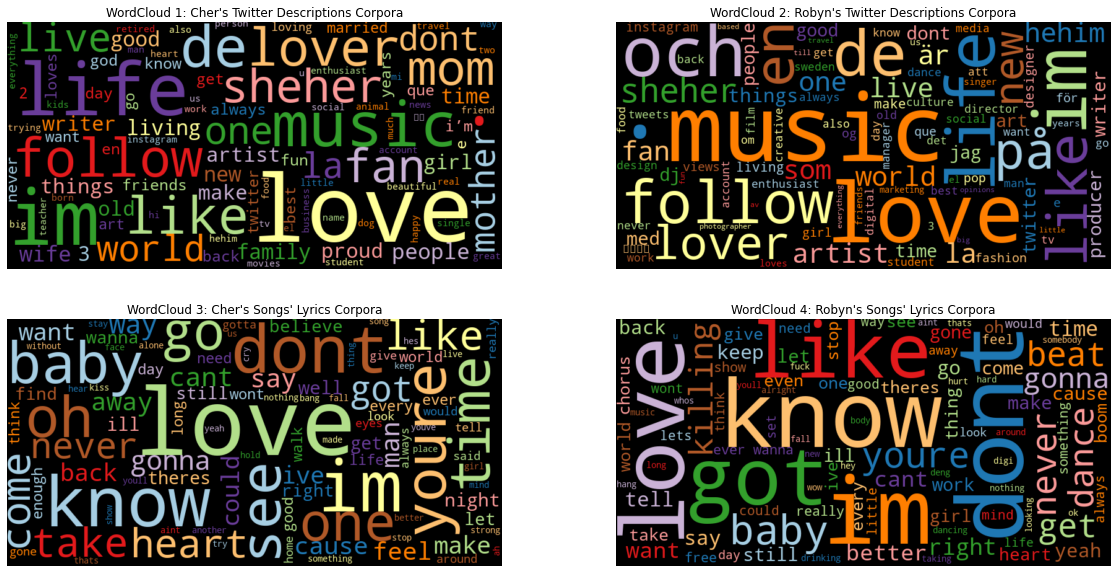

In [221]:
# Creating four WordClouds

plt.figure(figsize=(20,10))

# WordCloud 1 (Cher's Twitter Descriptions)
plt.subplot(2,2,1)
freq_tw_cher_df = count_words(df_cher_twitter)
wordcloud(freq_tw_cher_df['freq'], max_words=100)
plt.title("WordCloud 1: Cher's Twitter Descriptions Corpora")

# WordCloud 2 (Robyn's Twitter Descriptions)
plt.subplot(2,2,2)
freq_tw_robyn_df = count_words(df_robyn_twitter)
wordcloud(freq_tw_robyn_df['freq'], max_words=100)
plt.title("WordCloud 2: Robyn's Twitter Descriptions Corpora")

# WordCloud 3 (Cher's Lyrics)
plt.subplot(2,2,3)
freq_lyr_cher_df = count_words(df_cher_lyrics)
wordcloud(freq_lyr_cher_df['freq'], max_words=100)
plt.title("WordCloud 3: Cher's Songs' Lyrics Corpora")

# WordCloud 4 (Robyn's Lyrics)
plt.subplot(2,2,4)
freq_lyr_robyn_df = count_words(df_robyn_lyrics)
wordcloud(freq_lyr_robyn_df['freq'], max_words=100)
plt.title("WordCloud 4: Robyn's Songs' Lyrics Corpora")

plt.show()


Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The word "love" appears prominently all four corpora.